In [1]:
# libs
import warnings

import matplotlib.pyplot as plt
import matplotlib.image as img
from IPython.display import clear_output
from matplotlib import cm
import pandas as pd
import numpy as np

import re
import requests, io
from bs4 import BeautifulSoup
import json

import time
from tqdm.notebook import trange

from PIL import Image
from skimage.transform import resize

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:

! ls /content/sample_data 

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [3]:
def im_loader_to_matrix(df: pd.DataFrame):
    matricies_of_images = list()
    for i, s in zip(range(df.shape[0]+1), tqdm(range(df.shape[0]))):
        image = df['image'].iloc[i]
        image = requests.get(image).content
        image = plt.imread(io.BytesIO(image), format='JPG')
        matricies_of_images.append(image)
    
    df['image_matricies'] = matricies_of_images

In [4]:
def print_worktime(start):
    
    duration = time.time() - start
    duration = round(duration / 60, 3)
    
    print(f"Код отработал за: {duration} минут")

# Сохранение изображений в формате np.array

In [5]:
# при работе в Jupyter

# path_to_ds = r'D:\LIT-RE\Gapminder\Gapminder\\'
# ds_name = 'parsered_ds.xlsx'
# labels = pd.read_excel(path_to_ds + ds_name)

In [6]:
# при работе в Collab

# ds_name = 'parsered_ds.xlsx'
# df = pd.read_excel(ds_name)

In [7]:
# df.sample(5)

In [8]:
# start = time.time()

# im_loader_to_matrix(df)

# print_worktime(start)

In [9]:
# df.sample(5)

In [10]:
# labels = np.array(list(df['income']))
# images = np.array(list(df['image_matricies']))

In [11]:
# images[0].shape

In [12]:
# np.save('drive/MyDrive/images', images)

In [13]:
# np.save('drive/MyDrive/labels', labels)

# Подготовка трейн датасета




In [14]:
labels = np.load('drive/MyDrive/labels.npy', allow_pickle=True)
images = np.load('drive/MyDrive/images.npy', allow_pickle=True)

In [34]:
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torchvision import transforms

In [16]:
im_list = [resize(torch.as_tensor(im, dtype=torch.float32), (224, 224)) for im in images]
label_list = [torch.as_tensor(l, dtype=torch.float32) for l in labels]

In [17]:
type(im_list)

list

In [18]:
type(label_list)

list

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(im_list, label_list, test_size=0.1, random_state=42)

print("Train size = ", len(X_train))
print("Validation size = ", len(X_test))

Train size =  1659
Validation size =  185


In [21]:
# удаляем фото, несоответствующие размерности
X_test = [photo for photo in X_test if photo.shape == (224, 224, 3)]
X_train = [photo for photo in X_train if photo.shape == (224, 224, 3)]

In [22]:
len(X_test)

184

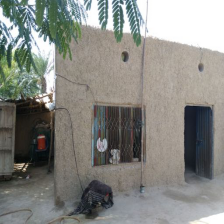

In [23]:
result = Image.fromarray(np.array(X_train[0]).astype(np.uint8))
result.convert('RGB')

# Собственная модель

In [24]:
# losses to minimize

def compute_loss(prediction, reference):
    """
    Расчет MSE
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ 
    Расчет MAE
    """
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [25]:
import random

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Нормализация пикселей изображения

Text(0.5, 1.0, 'Распределение пикселей')

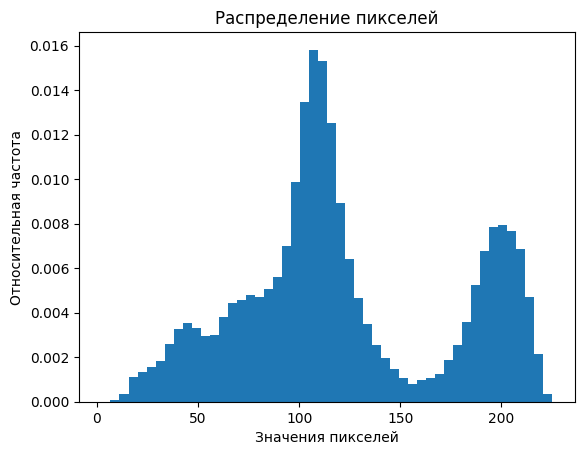

In [28]:
img_np = np.array(X_train[1000])
 
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("Значения пикселей")
plt.ylabel("Относительная частота")
plt.title("Распределение пикселей")

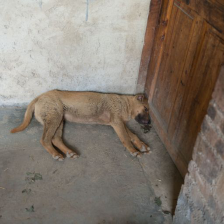

In [29]:
result = Image.fromarray(np.array(X_train[1000]).astype(np.uint8))
result.convert('RGB')

In [30]:
from torchvision import transforms
def normaliser(img: np.array):

  # test_img = X_train[1000]
  transform = transforms.Compose([
      transforms.ToTensor()
  ])
  img_tr = transform(img)
  mean, std = img_tr.mean([1,2]), img_tr.std([1,2])

  transform_norm = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
  ])

  img_normalized = transform_norm(img)

  return img_normalized

img_normalized = normaliser(X_train[1000])

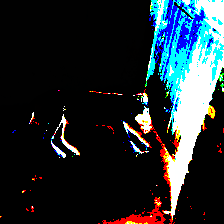

In [31]:
img_normalized = np.array(img_normalized)
img_normalized_tr = img_normalized.transpose(1, 2, 0)
result = Image.fromarray(np.array(img_normalized_tr).astype(np.uint8))
result.convert('RGB')

Text(0.5, 1.0, 'Распределение пикселей')

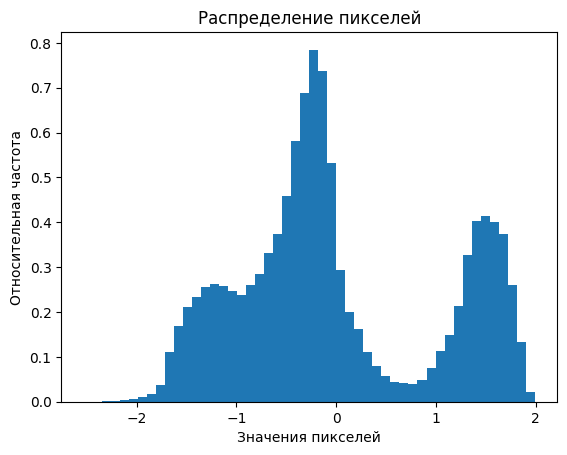

In [33]:
# img_np = np.array(X_train[0])
 
# plot the pixel values
plt.hist(img_normalized.ravel(), bins=50, density=True)
plt.xlabel("Значения пикселей")
plt.ylabel("Относительная частота")
plt.title("Распределение пикселей")

# Обучение CNN

In [86]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3),
    nn.BatchNorm2d(20),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2), 
    nn.Flatten(),
    nn.Linear(3380, 2700),
    nn.ReLU(),
    nn.Linear(2700, 2000),
    nn.ReLU(),
    nn.Linear(2000, 1500),
    nn.ReLU(),
    nn.Linear(1500, 1000),
    nn.ReLU(),
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Linear(500, 250), 
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(250, 100),
    nn.Linear(100, 1)       
)

opt = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(opt, gamma=0.1, step_size=10)

In [87]:
train_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.ColorJitter(),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize((32,32)),
                                 
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((32,32)),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [88]:
num_epochs = 100
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
batch_size = 50

# loss_func = nn.HuberLoss(delta=1.0)
loss_func = compute_loss

for epoch in range(num_epochs):
    
    running_loss = []
    running_corrects = []
    val_running_loss = []
    val_running_corrects = []
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for x_train, y_train in random.sample(list(zip(X_train, Y_train)), batch_size):
        # train on batch
        x_train = train_transforms(x_train)
        # x_train = normaliser(x_train)
        
        x_train = torch.reshape(x_train,(1,3, 32, 32))
        outputs = model(x_train)
        # print(outputs)
        # loss = compute_loss(y_train, outputs)
        loss = loss_func(outputs, y_train)
        loss.backward()
        opt.step()
        opt.zero_grad()
        _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
        running_loss.append(loss.item())
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
      for x_val, y_val in random.sample(list(zip(X_test, Y_test)), batch_size):
          x_val = test_transforms(x_val)
          x_val = torch.reshape(x_val,(1,3, 32, 32))
          # y_val = y_val
          y_out = model(x_val)
          val_loss = loss_func(y_out, y_val)
          # val_loss = compute_loss(y_val, y_out)
          _, y_pred = torch.max(y_out, 1)
          val_running_loss.append(val_loss.item())
    epoch_loss = np.mean(running_loss) # loss per epoch
    running_loss_history.append(epoch_loss) # appending for displaying 
    
    val_epoch_loss = np.mean(val_running_loss)
    val_running_loss_history.append(val_epoch_loss)
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}'.format(epoch_loss))
    print('validation loss: {:.4f}'.format(val_epoch_loss))

Epoch 1 of 100 took 17.314s
epoch : 1
training loss: 288393203677333225472.0000
validation loss: 1101068694719855360.0000
Epoch 2 of 100 took 16.173s
epoch : 2
training loss: 1935912271558475776.0000
validation loss: 35456588227375268.0000
Epoch 3 of 100 took 16.042s
epoch : 3
training loss: 41300256872421824.0000
validation loss: 5438635.0351
Epoch 4 of 100 took 15.743s
epoch : 4
training loss: 3002681.9146
validation loss: 4408570.5397
Epoch 5 of 100 took 15.951s
epoch : 5
training loss: 2895623.9608
validation loss: 3137778.4648
Epoch 6 of 100 took 17.587s
epoch : 6
training loss: 4053891.0176
validation loss: 3814884.0391
Epoch 7 of 100 took 16.820s
epoch : 7
training loss: 5462499.7017
validation loss: 3969156.2550
Epoch 8 of 100 took 16.670s
epoch : 8
training loss: 3780747.9845
validation loss: 4235824.2642
Epoch 9 of 100 took 15.707s
epoch : 9
training loss: 2677560.1807
validation loss: 3008022.0137
Epoch 10 of 100 took 15.190s
epoch : 10
training loss: 3779808.0484
validation

KeyboardInterrupt: ignored

In [92]:
model.eval() 

# Let's create a dummy input tensor  
dummy_input = torch.randn(1, X_train.shape, requires_grad=True)  

AttributeError: ignored

In [91]:
torch.onnx.export(model, 'customised_CNN.onnx')

TypeError: ignored

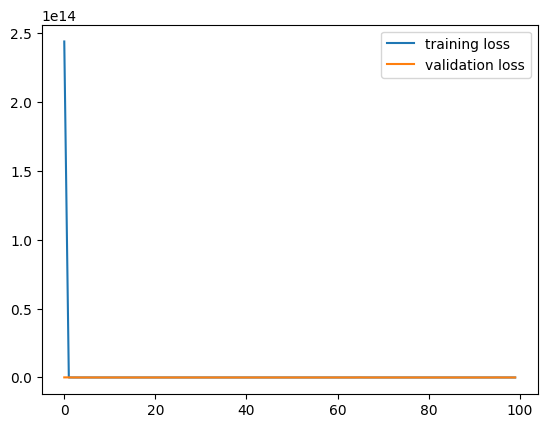

In [75]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [ ]:
running_loss_history

[6098268.263446655,
 4058707.862135696,
 2933779.899262695,
 2565815.390722656,
 4108604.4233764648,
 4673390.551592903,
 2119266.8117578123,
 4435542.43875,
 4495204.63748413,
 1705029.1017193603,
 3495469.2055407716,
 3435916.723227539,
 1731048.6280194093,
 3397308.619169922,
 1032026.4613720704,
 1852460.7945868874,
 2680469.9750976562,
 1527576.3119262694,
 1366500.2487402344,
 3425484.511741257,
 3098880.361647949,
 5340109.381654053,
 4324843.353867187,
 4515859.489199218,
 2350392.44359375,
 2557046.994331055,
 2830778.655484619,
 3285767.0673950193,
 2074623.3540722656,
 4466693.342440796,
 2498422.435979004,
 2568965.700397949,
 2491476.678692093,
 1324870.555834732,
 1691717.3894665528,
 2839514.0044335937,
 3205412.8664764403,
 2013967.24625,
 2464342.265546875,
 3705622.7479882813]

In [ ]:
print(x_train.shape)
model(X_train[0])

torch.Size([1, 3, 224, 224])


TypeError: ignored

In [ ]:
running_loss_history

[nan, nan, nan, nan, nan, nan, nan]

In [ ]:
loss = compute_loss(y_train, model(x_train))
loss.backward()
opt.step()
opt.zero_grad()

In [ ]:
loss

tensor(1542950.3750, grad_fn=<MeanBackward0>)

In [ ]:

x_train.shape

torch.Size([1, 3, 224, 224])

In [ ]:
model(test_image)

tensor([[nan]], grad_fn=<AddmmBackward0>)

In [ ]:
test_image = torch.as_tensor(X_train[1000],dtype=torch.float32)
test_image = torch.reshape(test_image,(1,3, 224, 224))
# test_image.requires_grad = True
model(test_image)

tensor([[nan]], grad_fn=<MulBackward0>)

In [ ]:
print(test_image.requires_grad)

False


In [ ]:
result = Image.fromarray(np.array((X_train[0]).astype(np.uint8))
result.convert('RGB')

SyntaxError: ignored

In [ ]:
for x_train in random.sample(list((X_train)), 2):
  print(x_train)

In [ ]:
outputs

tensor([[nan]], grad_fn=<MulBackward0>)

In [ ]:
x_train.shape

torch.Size([224, 224, 3])

In [ ]:
x_train.shape

torch.Size([341, 512, 3])

In [ ]:
X_train[0].clone().detach()

tensor([[[ 83., 112., 144.],
         [ 67.,  97., 123.],
         [ 74., 103., 117.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[163., 193., 221.],
         [154., 182., 204.],
         [ 72., 102., 112.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[132., 160., 181.],
         [141., 170., 184.],
         [ 75., 106., 109.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        ...,

        [[121., 127., 127.],
         [120., 126., 126.],
         [118., 124., 124.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[115., 119., 120.],
         [114., 118., 119.],
         [112., 116., 117.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[107., 111., 112.],
       